## Biostat M280 HW3
Due 05/19  

Julia Cheatsheet https://cheatsheets.quantecon.org/julia-cheatsheet.html

## Q1

Let $A=(a_{ij}) \in \{0,1\}^{n\times n}$ be the connectivity matrix of $n$ web pages with entries

$$
a_{ij}=\begin{cases}
1 & i\rightarrow j\\
0 & else
\end{cases}
$$

where $i \rightarrow j$ denotes an edge from page $i$ to $j$. Let $r_i = \sum_j a_{ij}$ denote the out-degree of page $i$.

Let $p$ denote the probability of randomly choosing a link $i \rightarrow j$ and $q = (1-p)$ the probability of randomly choosing one page of the set of all $n$ pages.   

Then $p_{ij}$ denotes the probability of transition $i \rightarrow j$

$$
p_{ij}=\begin{cases}
p\cdot\frac{a_{ij}}{r_i} + q\cdot\frac{1}{n} & r_i > 0\\
\frac{1}{n} & r_i = 0.
\end{cases}
$$

Let $P$ denote the transition matrixsad

$$
P = Q+R\cdot A
$$

where

$$
Q=\frac{1}{n}\cdot q\cdot1_{1\times n}
$$

with $q = (q_1,q_2,\ldots,q_n)^T \in \mathbb{R}^n$ with

$$
q_i=\begin{cases}
q, & r_i > 0\\
1, & r_i = 0
\end{cases}
$$

and

$$
R=\left(\begin{array}{cccc}
\widetilde{r}_{1} & 0 & \ldots & 0\\
0 & \widetilde{r}_{2} &  & \vdots\\
\vdots &  & \ddots & 0\\
0 & \cdots & 0 & \widetilde{r}_{n}
\end{array}\right)
$$

with

$$
\widetilde{r}_i=\begin{cases}
\frac{p}{r_i}, & r_i > 0\\
0, & r_i = 0.
\end{cases}
$$

## Q2

Let $P=(p_{ij})$ denote $\vert\Omega\vert\times\vert\Omega\vert$ transition matrix where $p_{ij} = P(x_{t+1}=j\vert x_t=i)$ with transition $i \rightarrow j$ for a Markov chain on $\Omega$ as stochastic process $\{X_0,X_1,\ldots,X_n\}$.
  
We assume $P$ is irreducable and aperiodic, that is the chain is ergodic. We observe $P$ is a non-negative row-stochastic matrix $P\cdot1=1$.
   
Then the fundamental theorem of Markov Chains states that there exists a unique stationary distribution $\pi$ as left-eigenvector such that $\pi^TP=\pi$ with spectral radius $\rho(P) = \max \left \{ |\lambda_1|, \cdots, |\lambda_n| \right \} = 1$. We omit the proof which is a direct consequence of the Perron-Frobenius theorem.
  
We formulate the above as classical eigen-value problem $P\pi=\lambda\pi$ which can be equivalently stated as $(P-\lambda I)\pi = 0.$ In our case, we obtain the linear system $(I-P^T)\pi = 0$. Observe $P\cdot1=1$ causes $\det(I-P^T)=0$ since the rows are not linearly independent or equivalently the sum of each column is zero. Since $\pi$ must be a probability distribution, we can further constraint the system with $\sum_i\pi_i=1$.

## Q3

In [1]:
A = readdlm("/home/juser/M230/hw3/A.txt", ',');
U = readdlm("/home/juser/M230/hw3/U.txt", ',');
inedges = sum(A,1);
outedges = sum(A,2);

In [14]:
"#pages = " * string(size(A)[1])

"#pages = 500"

In [15]:
"#links = " * string(sum(A))

"#links = 11158.0"

In [21]:
"#dangling = " * string(sum(outedges .< 1))

"#dangling 96"

In [26]:
U[indmax(inedges)]

"http://www.ucla.edu"

In [27]:
U[indmax(outedges)]

"http://giveto.ucla.edu"

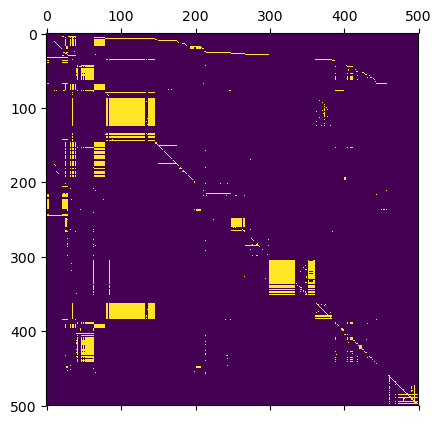

PyObject <matplotlib.image.AxesImage object at 0x7f356ca26e90>

In [29]:
using PyPlot
matshow(A)

## Q4

**1) LU **

In [30]:
function pr_lu(A, p)
    r = sum(A,2)
    (n,n) = size(A)
    q = r > 0 ? (p / r) : 0
end

pr_lu (generic function with 1 method)

**Benchmark**

In [3]:
As = sparse(A)
p = 0.85
pr_lu(As, p)

LoadError: UndefVarError: pr_lu not defined

In [4]:
    r = sum(A,2)
    (n,n) = size(A)
    q = r .> 0 ? (p / r) : 0

LoadError: MethodError: no method matching isless(::Int64, ::Array{Float64,2})[0m
Closest candidates are:
  isless(::Real, [1m[31m::AbstractFloat[0m) at operators.jl:41
  isless(::Real, [1m[31m::Real[0m) at operators.jl:75
  isless(::Integer, [1m[31m::Char[0m) at deprecated.jl:49[0m

In [9]:
q = r .> 0 ? (p / r) : 0

LoadError: TypeError: non-boolean (BitArray{2}) used in boolean context

In [7]:
r .> 0 ? true : false

LoadError: TypeError: non-boolean (BitArray{2}) used in boolean context

In [10]:
p = 0.85
(n,n) = size(A)
As = sparse(A)
r = sum(A,2)
q = 1/n * [r[i] > 0 ? (1-p) : 0 for i=1:n]
r_tilde = [r[i] > 0 ? (p / r[i]) : 0 for i=1:n]
RA = diagm(r_tilde) * As
Q = q * ones(1, n)
P = RA + Q

500×500 Array{Real,2}:
 0.0003     0.0306571  0.0306571  …  0.0003     0.0003     0.0003   
 0.0003     0.0003     0.0003        0.0003     0.0003     0.0003   
 0.0        0.0        0.0           0.0        0.0        0.0      
 0.0        0.0        0.0           0.0        0.0        0.0      
 0.0003     0.0003     0.0003        0.0003     0.0003     0.0003   
 0.0003     0.0003     0.0003     …  0.0003     0.0003     0.0003   
 0.0389364  0.0003     0.0003        0.0003     0.0003     0.0003   
 0.0124429  0.0003     0.0003        0.0003     0.0003     0.0003   
 0.0389364  0.0003     0.0003        0.0003     0.0003     0.0003   
 0.0389364  0.0003     0.0003        0.0003     0.0003     0.0003   
 0.0191889  0.0003     0.0003     …  0.0003     0.0003     0.0003   
 0.0389364  0.0003     0.0003        0.0003     0.0003     0.0003   
 0.0372565  0.0003     0.0003        0.0003     0.0003     0.0003   
 ⋮                                ⋱                                 
 0.0003    

In [18]:
# LU
I_P = (eye(n) - P') + diagm(ones(n))
I_P[1,:] = 1
b = [1; zeros(n-1)]
x = lufact(I_P) \ b

500-element Array{Float64,1}:
 0.551472   
 0.00855409 
 0.00906419 
 0.00905661 
 0.00855409 
 0.00855409 
 0.00855409 
 0.00855409 
 0.00855409 
 0.00855409 
 0.00855409 
 0.00876295 
 0.00873464 
 ⋮          
 0.000196786
 0.000196786
 0.000192216
 0.000317211
 0.000229338
 0.000196786
 0.000196786
 0.000595624
 0.000196786
 0.000196786
 0.000196786
 0.000175877

## Q5

In [25]:
using DataFrames
indegree = sum(A,1);
outdegree = sum(A,2);
rank = sortperm(x, rev=true)[1:20]
df = DataFrame(Url = U[rank], Rank = x[rank], In = indegree[rank], Out = outdegree[rank])

,Url,Rank,In,Out
1,http://www.ucla.edu,0.5514724724324079,171.0,28.0
2,http://www.directory.ucla.edu,0.012055605523013886,112.0,40.0
3,http://happenings.ucla.edu,0.011418694089603528,71.0,13.0
4,http://www.universityofcalifornia.edu,0.010915188840624635,53.0,35.0
5,http://www.registrar.ucla.edu/calendar,0.010675070620742442,55.0,24.0
6,http://twitter.com/ucla,0.009586676595424738,37.0,0.0
7,http://www.facebook.com/uclabruins,0.009422023976387485,33.0,0.0
8,http://www.instagram.com/ucla,0.00939719682848854,30.0,0.0
9,http://youtube.ucla.edu,0.009333271199294758,35.0,4.0
10,http://www.atmos.ucla.edu/weather/quick-look,0.009064189245082434,27.0,0.0
